# This notebook is to extract and save data into hdf5 format

In [1]:
JSON_FILE_IDX = 0    # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

In [2]:
SAVE_TO_HDF5 = 0
SAVE_SUMMARY = 0

## 1. setup

In [3]:
import os
import sys
sys.path.append('../')
home_dir = '/Users'
proj_dir = home_dir + '/dlee/imaging/'

In [4]:
import numpy as np
import scipy.io
import scipy.signal
import cv2
import json
import h5py
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import utils
import stats

## 2. Load .json file

In [5]:
json_file_list = ['0.json', '1.json', '2.json',              # 23-06-16    
                  '3.json', '4.json',                        # 23-06-20
                  '5.json', '6.json', '7.json', '8.json',    # 23-06-26
                  '9.json']                                  # 23-06-26 sort2
json_file = json_file_list[JSON_FILE_IDX]

In [6]:
with open(proj_dir + 'json/' + json_file, 'r') as js:
    p = json.load(js)
print(p.keys())
print(p['exp_id'], '\t', p['pd_trace'])

dict_keys(['exp_id', 'exp_date', 'exp_session', 'roi_trace', 'roi_snap', 'p', 'pd_trace', 'pd_threshold', 'cc', 'ccNote', 'loc', 'wn', 'nm', 'zoom', 'laser_percent', 'GCL', 'INL', 'INLNote', 'flipTime', 'test_repeat', 'test_seed', 'test_fr', 'test_totalFrame', 'test_totalFrame30', 'test_totalFrame60', 'test_box_size', 'train_repeat', 'train_seed', 'train_fr', 'train_totalFrame', 'train_totalFrame30', 'train_totalFrame60', 'train_box_size', 'roi_threshold', 'resp_idx', 'n_before', 'n_after', 'space_1_idx', 'space_2_idx', 'space_sigma', 'time_sigma'])
9 	 23-06-26-loc3-wn-pd_trace.mat


In [7]:
session_dir = proj_dir + 'data-sort/' + p['exp_date'] + '/' + p['exp_session'] + '/'

## 3. Load photodiode

In [8]:
m_pd = scipy.io.loadmat(session_dir + p['pd_trace'])
pd = stats.zero_one(m_pd['pd_trace'].ravel())
pd.shape

(126120,)

In [9]:
maxtab, _ = spk.peakdet(pd, p['pd_threshold'])
idx1 = np.int64(maxtab[:, 0])[0::2]
idx2 = np.int64(maxtab[:, 0])[1::2]
idx1, idx2

(array([  459,  4017,  7575, 11132, 14690, 18248]),
 array([  3954,   7512,  11069,  14627,  18185, 125890]))

## 4. Load roi_trace

In [10]:
roi_filename = (session_dir + p['roi_trace'])[:-4]
m_roi = scipy.io.loadmat(roi_filename + '.mat')['roi_trace']
m_roi_p = scipy.io.loadmat(roi_filename + '_p' + str(p['p']) + '.mat')['roi_trace']
m_roi_n = scipy.io.loadmat(roi_filename + '_n' + str(p['p']) + '.mat')['roi_trace']
#rt = m_roi - (m_roi_p + m_roi_n)/2       # raw trace (background subtracted)
#rt.shape

In [11]:
n_roi = m_roi.shape[1]
n_roi

283

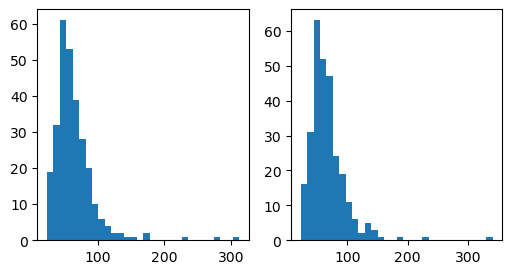

In [12]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(121)
ax.hist(np.std(m_roi_p, 0), 30,);
ax = plt.subplot(122)
ax.hist(np.std(m_roi_n, 0), 30,);

In [13]:
p_std = np.std(m_roi_p, 0)
n_std = np.std(m_roi_n, 0)
for r in range(n_roi):
    if p_std[r] > p['roi_threshold'][0]:
        m_roi_p[:, r] = np.nan
        m_roi_p[:, r] = np.nanmean(np.stack([m_roi_p[:, r - 2], m_roi_p[:, r - 1], m_roi_p[:, r + 1], m_roi_p[:, r + 2]]), 0)
    if n_std[r] > p['roi_threshold'][1]:
        m_roi_n[:, r] = np.nan
        m_roi_n[:, r] = np.nanmean(np.stack([m_roi_n[:, r - 2], m_roi_n[:, r - 1], m_roi_n[:, r + 1], m_roi_n[:, r + 2]]), 0)

In [14]:
rt = m_roi - (m_roi_p + m_roi_n)/2       # raw trace (background subtracted)
rt.shape

(63060, 283)

In [15]:
# calculate df and normalize by variance
rt_us = st.upsample(rt, 2)[0].swapaxes(0, 1)
rt_us = np.stack([(rt_us[r, :] - stats.get_f(rt_us[r, :], 1200)) for r in range(n_roi)])
rt_us = np.stack([stats.var_normalize(rt_us[r, :], 1800) for r in range(n_roi)])
rt_us = np.stack([stats.normalize(rt_us[r, :]) for r in range(n_roi)])

# automatically play sound 
#os.system("printf '\a'")

In [16]:
# calculate df/f and normalize by variance
#rt_us = np.stack([stats.df_over_f(rt_us[r, :], 1200) for r in range(n_roi)])       # delta_f_over_f unstable for some conditions
#rt_us = np.stack([stats.var_normalize(rt_us[r, :], 1200) for r in range(n_roi)])

In [17]:
n_te = p['test_repeat']
n_tr = p['train_repeat']
n_total = n_te + n_tr

In [18]:
if p['test_repeat'] > 0:
    idx_diff = (idx2 - idx1)[:n_te]
    idx1_te = idx1[:n_te]
    idx2_te = idx1_te + int(np.round(idx_diff.mean())) # because idx2[:n_te] different over trials
idx1_tr = idx1[n_te:n_total][0]
idx2_tr = idx2[n_te:n_total][0]

In [19]:
(idx2_tr-idx1_tr)/2

53821.0

In [20]:
rt_rs_tr = np.stack([stats.normalize(scipy.signal.resample(utils.butter_lf(rt_us[r, :], Wn_l=6.0, fs=60)[idx1_tr:idx2_tr], p['train_totalFrame30']))
                     for r in range(n_roi)])
if p['test_repeat'] > 0:
    rt_rs_te = np.stack([np.stack([stats.normalize(scipy.signal.resample(utils.butter_lf(rt_us[r, :], Wn_l=6.0, fs=60)[idx1_te[t]:idx2_te[t]], p['test_totalFrame30'])) 
                                   for r in range(n_roi)]) for t in range(p['test_repeat'])])
else:
    rt_rs_te = np.nan
    
if p['test_repeat'] > 0:
    print(rt_rs_tr.shape, rt_rs_te.shape)
else:
    print(rt_rs_tr.shape)

(283, 53900) (5, 283, 1750)


In [21]:
#rt_rs_tr = np.stack([scipy.signal.resample(rt_us[r, idx1_tr:idx2_tr], p['train_totalFrame30']) 
#                     for r in range(n_roi)])
#if p['test_repeat'] > 0:
#    rt_rs_te = np.stack([np.stack([scipy.signal.resample(rt_us[r, idx1_te[t]:idx2_te[t]], p['test_totalFrame30']) 
#                                   for r in range(n_roi)]) for t in range(p['test_repeat'])])
#else:
#    rt_rs_te = np.nan
#    
#if p['test_repeat'] > 0:
#    print(rt_rs_tr.shape, rt_rs_te.shape)
#else:
#    print(rt_rs_tr.shape)

In [22]:
if p['test_repeat'] > 0:
    te_cc_val = np.nanmean(stats.corr(rt_rs_te.swapaxes(0, 1), mode='mean')[:, :, 0], 1)
    te_cc_rank = np.argsort(np.argsort(te_cc_val)[::-1])
    te_cc_val_rank = np.stack((te_cc_val, te_cc_rank)).T
    print(te_cc_val_rank.shape)
else:
    te_cc_val_rank = np.nan

(283, 2)


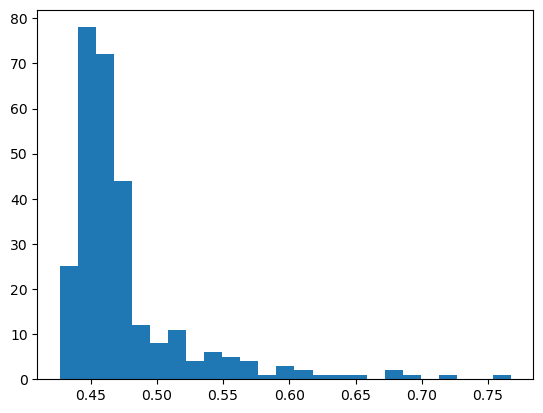

In [23]:
if p['test_repeat'] > 0:
    plt.hist(te_cc_val_rank[:, 0], 25)

## 5. Load time

In [24]:
dt = p['flipTime']/(30/p['train_fr'])
print(dt)

0.03336460114


In [25]:
tbins_tr = np.arange(0, dt*p['train_totalFrame30'], dt)
if p['test_repeat'] > 0:
    tbins_te = np.arange(0, dt*p['test_totalFrame30'], dt)
    print(tbins_tr.shape, tbins_te.shape)
else:
    tbins_te = np.nan
    print(tbins_tr.shape)

(53900,) (1750,)


## 6. Load visual stimulus

In [26]:
stim_dir = proj_dir + 'matrix/'
stim_dir_tr = stim_dir + p['train_seed'] + '/'
if p['test_repeat'] > 0:
    stim_dir_te = stim_dir + p['test_seed'] + '/'
stim_dir_tr

'/Users/dlee/imaging/matrix/0/'

In [27]:
if p['nm'] == 1:         # natural movie
    stim_file_tr = stim_dir_tr + 'mov_sample_' + p['train_seed'] + '.mat'
    if p['test_repeat'] > 0:
        stim_file_te = stim_dir_te + 'mov_sample_' + p['test_seed'] + '.mat'
else:                    # white noise
    stim_file_tr = stim_dir_tr + 'boxColor_w8_' + p['train_seed'] + '.mat'
    if p['test_repeat'] > 0:
        stim_file_te = stim_dir_te + 'boxColor_w8_' + p['test_seed'] + '.mat'

if p['test_repeat'] > 0:
    print(stim_file_tr, stim_file_te)
else:
    print(stim_file_tr)

/Users/dlee/imaging/matrix/0/boxColor_w8_0.mat /Users/dlee/imaging/matrix/1/boxColor_w8_1.mat


In [28]:
if p['nm'] == 1:  # natural movie
    stim_tr = utils.rescale(np.double(scipy.io.loadmat(stim_file_tr)['mov_sample']))[:, 9:-9, 9:-9]    # 30 Hz
    stim_tr = st.upsample(stim_tr, int(np.round(30/p['train_fr'])))[0][:p['train_totalFrame30']]
    if p['test_repeat'] > 0:
        stim_te = utils.rescale(np.double(scipy.io.loadmat(stim_file_te)['mov_sample']))[:, 9:-9, 9:-9]
        stim_te = st.upsample(stim_te, int(np.round(30/p['test_fr'])))[0][:p['test_totalFrame30']]
    else:
        stim_te = np.nan
else:             # white noise
    stim_tr = st.downsample(utils.load_stimulus_wn(stim_file_tr), 2)[0]                                # 30 Hz
    stim_tr = st.upsample(stim_tr, int(np.round(30/p['train_fr'])))[0][:p['train_totalFrame30']]
    if p['test_repeat'] > 0:
        stim_te = st.downsample(utils.load_stimulus_wn(stim_file_te), 2)[0]
        stim_te = st.upsample(stim_te, int(np.round(30/p['test_fr'])))[0][:p['test_totalFrame30']]
    else:
        stim_te = np.nan

## 7. Load jitter

In [29]:
jitter_dir = proj_dir + 'matrix/'

In [30]:
if p['nm'] == 1:         # natural movie
    jitter_file = jitter_dir + 'jitter.mat'
    jitter_raw = np.round(scipy.io.loadmat(jitter_file)['jitter'][::-1, :78000] * 0.75)/2    # 30 Hz, x-y flip, jitter means "indexing", unit [pixel]
    jitter_tr = jitter_raw[:, :p['train_totalFrame30']]   # on screen, index=0: vertical direction, (+) means visual scene drift upward 
                                                          #            index=1: horizontal directin, (+) means visual scene drift to left             
    if p['test_repeat'] > 0:
        jitter_te = jitter_raw[:, 72000:72000 + p['test_totalFrame30']]
    else:
        jitter_te = np.nan
else:                    # white noise
    jitter_tr = np.nan
    jitter_te = np.nan

## 8. Save as h5

In [31]:
h5_dir = proj_dir + 'data-extract/'
h5_file = str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '.h5'

In [32]:
if SAVE_TO_HDF5 == 1:
    with h5py.File(h5_dir + h5_file, 'w') as f:
        f.create_dataset('train/stim', data=stim_tr)
        f.create_dataset('train/resp', data=rt_rs_tr)
        f.create_dataset('train/tbins', data=tbins_tr)
        f.create_dataset('train/jitter', data=jitter_tr)
        f.create_dataset('test/stim', data=stim_te)
        f.create_dataset('test/resp', data=rt_rs_te)
        f.create_dataset('test/tbins', data=tbins_te)
        f.create_dataset('test/jitter', data=jitter_te)
        f.create_dataset('test/cc', data=te_cc_val_rank)

## 9. Summary 

In [33]:
summary_dir = proj_dir + 'data-extract/'
summary_file = str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '.pdf'

In [34]:
snap_filename = session_dir + p['roi_snap']
img = cv2.imread(snap_filename, cv2.IMREAD_UNCHANGED)

In [35]:
if n_roi < 20:
    select_num = n_roi
else:
    select_num = 20
if p['test_repeat'] > 0:
    selected_rois_idx = np.argsort(te_cc_val_rank[:, 1])[:select_num]
else:
    selected_rois_idx = np.argsort(np.std(rt, 0))[::-1][:select_num]
selected_rois_idx

array([211, 196, 282,  11, 233, 109, 132, 255, 157, 171, 202, 268, 101,
       182, 190, 177, 141, 172, 121, 123])

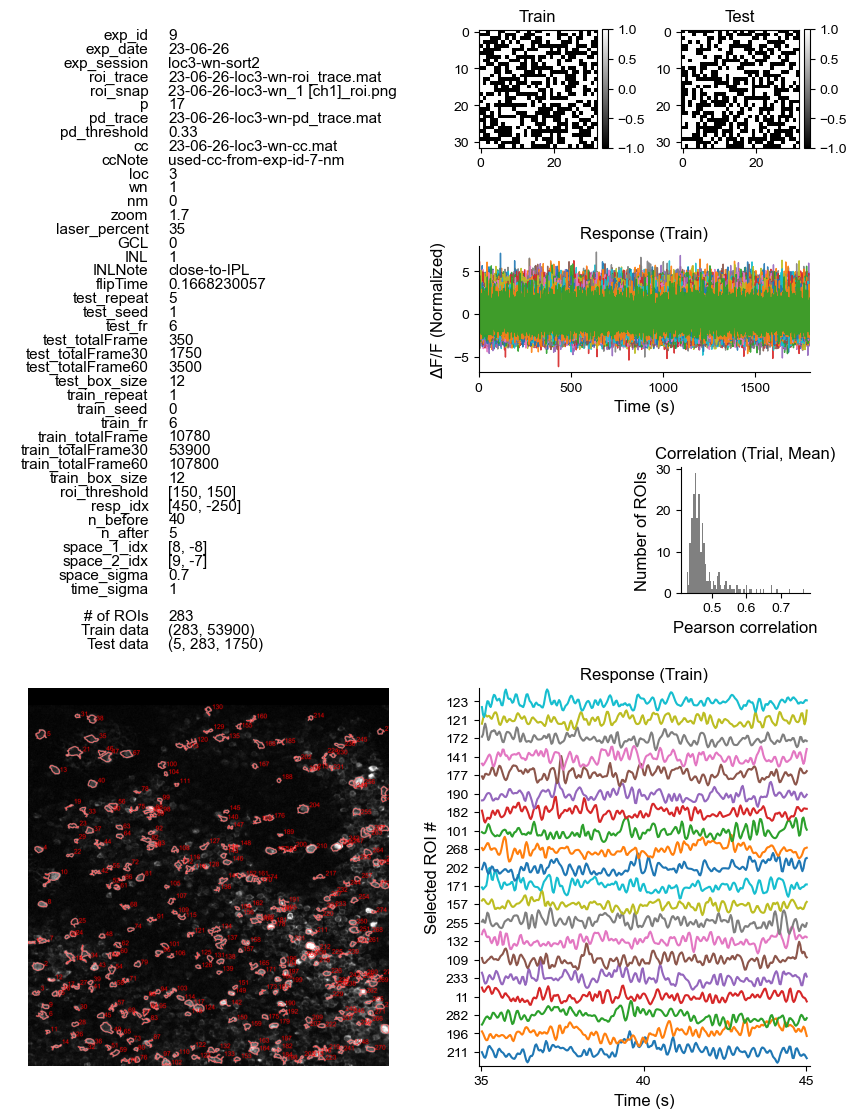

In [36]:
l = 10
plt.rcParams["font.family"] = "Arial"

fig = plt.figure(figsize=(l, l * 1.3))
gs = fig.add_gridspec(4, 4,  width_ratios=(1.5, 1, 1, 1), height_ratios=(1, 1, 1, 3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.5, hspace=0.5)

# summary ########################################################################################
ax = plt.subplot(gs[0:3, 0:2])
for i, j in enumerate(p):
    ax.text(0.35, len(p.keys())-i-1, j, ha='right', fontsize=11)
    ax.text(0.4, len(p.keys())-i-1, p[j], fontsize=11)
ax.text(0.35, -2, '# of ROIs', ha='right', fontsize=11)
ax.text(0.4, -2, n_roi, fontsize=11)
ax.text(0.35, -3, 'Train data', ha='right', fontsize=11)
ax.text(0.4, -3, rt_rs_tr.shape, fontsize=11)
ax.text(0.35, -4, 'Test data', ha='right', fontsize=11)
if p['test_repeat'] > 0:
    ax.text(0.4, -4, rt_rs_te.shape, fontsize=11)
else:
    ax.text(0.4, -4, 'N/A', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, len(p.keys())])
ax.axis('off')

# visual stimulus ################################################################################
ax = plt.subplot(gs[0, 2])
im = ax.imshow(stim_tr[0, :, :], cmap='gray', vmin=-1, vmax=1, interpolation='nearest')
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
ax.set_title('Train', fontsize=12)
ax = plt.subplot(gs[0, 3])
if p['test_repeat'] > 0:
    im = ax.imshow(stim_te[0, :, :], cmap='gray', vmin=-1, vmax=1, interpolation='nearest')
    cb = plt.colorbar(im, fraction=0.046, pad=0.04)
    ax.set_title('Test', fontsize=12)
else:
    ax.axis('off')

# response (train), jitter (for natural movie), and correlation (test; trial-mean) ###############
ax = plt.subplot(gs[1, 2:4])
ax.plot(tbins_tr, rt_rs_tr.T, linewidth=1, alpha=0.9);
ax.set_xlim([tbins_tr[0], tbins_tr[-1]])
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel(r'$\Delta$F/F (Normalized)', fontsize=12)
ax.set_title('Response (Train)', fontsize=12)
ax = plt.subplot(gs[2, 2])
if p['nm'] == 1:
    ax.plot(tbins_tr[:150], jitter_tr[:, :150].T)
    ax.set_xlim([tbins_tr[0], tbins_tr[150]])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Global motion (pixel)', fontsize=12)
    ax.set_title('Jitter', fontsize=12)
else:
    ax.axis('off') 
ax = plt.subplot(gs[2, 3])
if p['test_repeat'] > 0:
    ax.hist(te_cc_val_rank[:, 0], int((te_cc_val_rank[:, 0].max() - te_cc_val_rank[:, 0].min())/0.004), 
            [te_cc_val_rank[:, 0].min(), te_cc_val_rank[:, 0].max()], color='gray')
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
    ax.set_xlabel('Pearson correlation', fontsize=12)
    ax.set_ylabel('Number of ROIs', fontsize=12)
    ax.set_title('Correlation (Trial, Mean)', fontsize=12)
else:
    ax.axis('off')

# snap image and response (selected ROIs) ########################################################
ax = plt.subplot(gs[3, 0:2])
im = ax.imshow(img[:, :, ::-1])
ax.axis('off')
ax = plt.subplot(gs[3, 2:4])
for r in range(select_num):
    ax.plot(tbins_tr[1050:1050+300], rt_rs_tr[selected_rois_idx[r], 1050:1050+300]/4 + r);
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1))
ax.set_xlim([tbins_tr[1050:1050+300][0]-0.1, tbins_tr[1050:1050+300][-1]+0.1])
ax.set_ylim([-0.75, select_num-0.25])
#ax.set_yticklabels(np.arange(21))
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(np.arange(select_num)))
ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter(selected_rois_idx))
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Selected ROI #', fontsize=12)
ax.set_title('Response (Train)', fontsize=12)

# save #############################################################################################
if SAVE_SUMMARY:
    plt.savefig(summary_dir + summary_file, dpi=400, format='pdf', bbox_inches='tight')